### Redes Neurais e Aprendizado Profundo
#### **MBA em Ciências de Dados**

### Módulo 5 - Redes neurais para dados sequenciais </span>

#### <span style="color:darkred">**Camada Self-Attention** combinada com LSTM</span>

Moacir Antonelli Ponti

---

In [ ]:
import numpy as np
from pandas import read_csv

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

from numpy.random import seed
from tensorflow.random import set_seed

from sklearn.metrics import mean_squared_error
from math import sqrt

# outros
df = read_csv('Alcohol_Sales.csv')
#df = read_csv('data/Miles_Traveled.csv')
#df = read_csv('data/starbucks.csv')
#df = read_csv('data/passengers.csv')
#df = read_csv('data/price_of_ground_chuck.csv')

# pega segunda coluna do dataframe
var = df.columns.values[1]

Série:  S4248SM144NCEN
Tamanho da série:  325


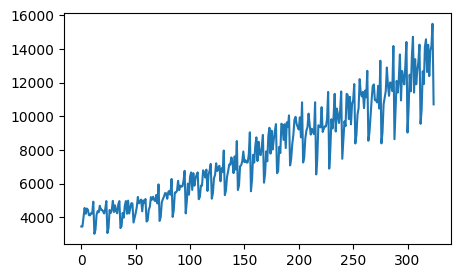

In [ ]:
series = np.array(df[var])
fig = plt.figure(figsize=(5,3))
plt.plot(series)
N = series.shape[0]

print("Série: ", var)
print("Tamanho da série: ", N)

## Parte 1: Preparando os dados

1. **Separação em treinamento e teste**: o treinamento sempre deve vir antes do teste no caso de dados sequenciais
2. **Normalização**: aqui utilizaremos a normalização Min-Max para 0-1
3. **Inserção de ruído opcional**: no treinamento e teste para avaliação da robustez dos modelos
4. **Formulação como aprendizado supervisionado**: adequando os arrays de forma a permitir uso nas redes neurais

In [ ]:
# calcula tamanhos dos dados de treinamento (n_train) e teste (n_test)
porc_treinamento = 70

n_train = int(len(series)*(porc_treinamento/100.0))
n_test = len(series)-n_train+1

train_x = series[:n_train]
test_x = series[n_train-1:]

# normalização min-max com base no treinamento
vmax = train_x.max()
vmin = train_x.min()

train_x_norm = (train_x - vmin)/(vmax - vmin)
test_x_norm = (test_x - vmin)/(vmax - vmin)

print("Exemplos de Treinamento: ", n_train)
print("Exemplos de Teste: ", n_test)

Exemplos de Treinamento:  227
Exemplos de Teste:  99


In [ ]:
inserir_ruido_serie = False
inserir_ruido_teste = False
porc_ruido = 10.0

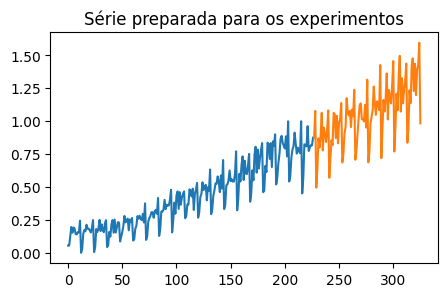

In [ ]:
seed(1)
set_seed(1)

# insere ruido na serie
if (inserir_ruido_serie):
    train_x_norm = train_x_norm + np.random.randn(n_train)*(porc_ruido/100.0)

# insere ruido apenas no teste
if (inserir_ruido_teste):
    test_x_norm = test_x_norm + np.random.randn(n_test)*(porc_ruido/100.0)

fig = plt.figure(figsize=(5,3))
plt.plot(np.arange(0, n_train), train_x_norm)
plt.plot(np.arange(n_train,n_train+n_test), test_x_norm)
ax = plt.title('Série preparada para os experimentos')

#### Formulação para aprendizado supervisionado: adequação dos arrays

Podemos cumprir essa etapa utilizando a observação do último passo $t-1$ como entrada e a observação atual $t$ como saída.

Podemos alcançar isso deslocando todos os valores da série por um número específico de posições. Aqui vamos deslocar 1 posição para trás, que se tornarão as variáveis de entrada, sendo que a série temporal original será considerada como a variável de saída.

In [ ]:
# modifica a serie temporal tornando-a um problema de aprendizado supervisionado
# retornando array de entrada x e de saída y
def timeseries_to_supervised_dense(series, look_back=1):
    # o reshape com -1 preenche a dimensão conforme necessário, nesse caso teremos (num_valores, 1)
    x = np.reshape(np.array(series[:-look_back]), (-1, 1))
    y = np.reshape(np.array(series[look_back:]), (-1, 1))
    return x, y

In [ ]:
look_back = 1
train_x_dense, train_y_dense = timeseries_to_supervised_dense(train_x_norm, look_back=look_back)

# numero de features na série
no_features = train_x_dense.shape[1]

print('Tamanho dos arrays de treinamento x e y')
print(train_x_dense.shape)
print(train_y_dense.shape)

print('\nPrimeiros 4 elementos de x e y')
print(train_x_dense[:4])
print(train_y_dense[:4])

Tamanho dos arrays de treinamento x e y
(226, 1)
(226, 1)

Primeiros 4 elementos de x e y
[[0.05478751]
 [0.0546595 ]
 [0.12429595]
 [0.19623656]]
[[0.0546595 ]
 [0.12429595]
 [0.19623656]
 [0.15232975]]


## Parte 2 : Utilizando LSTMs para predição

Agora utilizaremos uma rede neural baseada em camada recorrente, permitindo aprender a sequência.

Uma camada LSTM espera como entrada um tensor com as seguintes dimensões:

samples x time_steps x features

* *Samples* são as observações independentes do domínio, tipicamente colunas de dados, consideradas no batch

* *Time steps* são os passos temporais separados de uma dada variável para uma dada observação - quantas observações serão dadas como entrada antes de que a primeira saída seja obtida

* *Features* são as medidas separadas observada em cada tempo da observação - quantos valores são considerados em cada entrada

No caso dessa base de dados, podemos usar diferentes configurações. Para manter simples, consideramos que o problema em cada passo de tempo é uma amostra individual, com um time step e uma feature apenas.


In [ ]:
# formato deve ser [samples, time steps, features]
def recurrent_array(train_x, time_steps=1):

    array = np.array(np.reshape(train_x, (-1, 1)), copy=True)

    train_y_ts = array[time_steps:]
    train_x_ts = []
    for i in range(0, len(array) - time_steps):
        train_x_ts.append(array[i:i+time_steps])

    train_x_ts = np.array(train_x_ts)

    #rec_array = np.reshape(array, (array.shape[0], time_steps, array.shape[1]))
    return train_x_ts, train_y_ts

In [ ]:
time_steps = 2

train_x_rec, train_y_rec = recurrent_array(train_x_norm, time_steps=time_steps)

test_x_rec, test_y_rec = recurrent_array(test_x_norm,time_steps=time_steps)

In [ ]:
print('Dados de treinamento para rede recorrente')
print('Tamanho dos arrays de teste x e y')
print(train_x_rec.shape)
print(train_y_rec.shape)

print('\nPrimeiros 4 elementos de treinamento x e y')
print(train_x_rec[:4])
print(train_y_rec[:4])

Dados de treinamento para rede recorrente
Tamanho dos arrays de teste x e y
(225, 2, 1)
(225, 1)

Primeiros 4 elementos de treinamento x e y
[[[0.05478751]
  [0.0546595 ]]

 [[0.0546595 ]
  [0.12429595]]

 [[0.12429595]
  [0.19623656]]

 [[0.19623656]
  [0.15232975]]]
[[0.12429595]
 [0.19623656]
 [0.15232975]
 [0.19175627]]


In [ ]:
train_x_dense[:6]

array([[0.05478751],
       [0.0546595 ],
       [0.12429595],
       [0.19623656],
       [0.15232975],
       [0.19175627]])

#### Rede com unidades LSTM

In [ ]:
batch_size = 1

seed(1)
set_seed(1)

def create_LSTM(no_features, time_steps, hidden_units=10, activation='relu', do_rate=0.2):

    x = layers.Input(shape=(time_steps, no_features))

    lstm_x = layers.LSTM(hidden_units, return_sequences=True, activation=activation)(x)
    lstm_x = layers.LSTM(hidden_units, activation=activation)(lstm_x)

    drop = layers.Dropout(do_rate)(lstm_x)
    outputs = layers.Dense(1, trainable=True, activation=activation)(drop)
    model = tf.keras.models.Model(x, outputs)
    return model

modelLSTM = create_LSTM(no_features, time_steps, hidden_units=16, do_rate=0.25)
modelLSTM.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 2, 16)             1152      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3281 (12.82 KB)
Trainable params: 3281 (12.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
epochs = 35

# decaimento de learning rate
def scheduler(epoch, lr):
    #if (epoch % 20 == 0): print("Época %04d - learning rate %.9f" % (epoch, lr))
    if (epoch+1 < 5):
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.02),9)

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

modelLSTM = create_LSTM(no_features, time_steps, hidden_units=16, do_rate=0.25)

# compilacao e treinamento
modelLSTM.compile(loss='mean_squared_error',
            optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0002),
            metrics=['mae'])

histLSTM = modelLSTM.fit(train_x_rec, train_y_rec,
                  batch_size=batch_size, epochs=epochs,
                  callbacks=[callbacklr], shuffle=False,
                  verbose=1)

Epoch 1/35
225/225 [==============================] - 13s 11ms/step - loss: 0.2035 - mae: 0.3960 - lr: 2.0000e-04
Epoch 2/35
225/225 [==============================] - 2s 10ms/step - loss: 0.1400 - mae: 0.3084 - lr: 2.0000e-04
Epoch 3/35
225/225 [==============================] - 2s 10ms/step - loss: 0.0909 - mae: 0.2335 - lr: 2.0000e-04
Epoch 4/35
225/225 [==============================] - 3s 11ms/step - loss: 0.0605 - mae: 0.1966 - lr: 2.0000e-04
Epoch 5/35
225/225 [==============================] - 3s 12ms/step - loss: 0.0549 - mae: 0.1944 - lr: 1.9604e-04
Epoch 6/35
225/225 [==============================] - 3s 13ms/step - loss: 0.0523 - mae: 0.1883 - lr: 1.9216e-04
Epoch 7/35
225/225 [==============================] - 3s 12ms/step - loss: 0.0441 - mae: 0.1777 - lr: 1.8835e-04
Epoch 8/35
225/225 [==============================] - 2s 7ms/step - loss: 0.0485 - mae: 0.1824 - lr: 1.8462e-04
Epoch 9/35
225/225 [==============================] - 2s 10ms/step - loss: 0.0430 - mae: 0.1717 

Scores treinamento
MSE: 0.0146
MAE: 0.0930


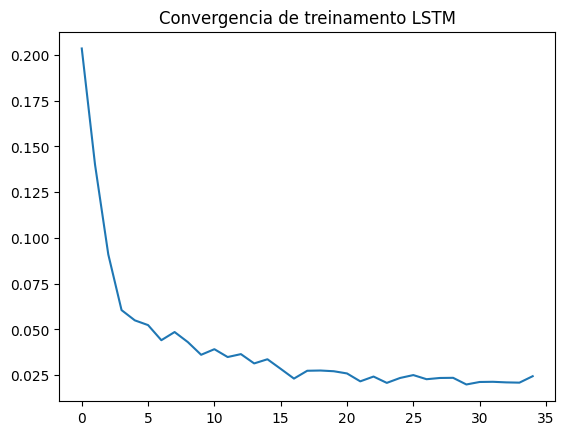

In [ ]:
scores = modelLSTM.evaluate(train_x_rec, train_y_rec, verbose=0)
print('Scores treinamento')
print('MSE: %.4f' % (scores[0]))
print('MAE: %.4f' % (scores[1]))

plt.plot(histLSTM.history['loss'])
ax = plt.title('Convergencia de treinamento LSTM')

In [ ]:
# realiza predicoes com os dados de treinamento e teste
train_y_predL = modelLSTM.predict(train_x_rec)
train_y_predL = np.reshape(train_y_predL, (-1, 1))[time_steps:]

test_y_predL = modelLSTM.predict(test_x_rec)
test_y_predL = np.reshape(test_y_predL, (-1, 1))[time_steps:]

4/4 [==============================] - 0s 3ms/step


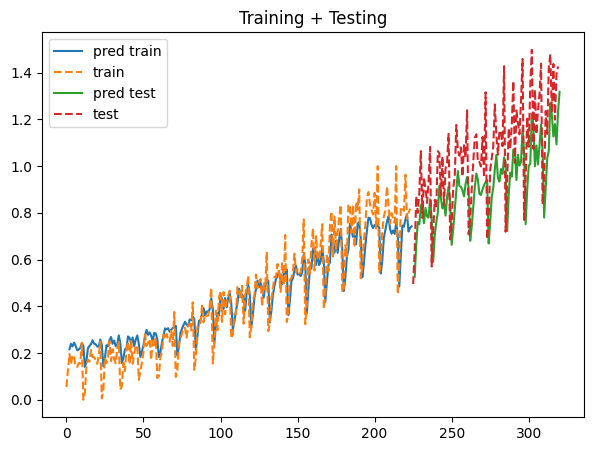

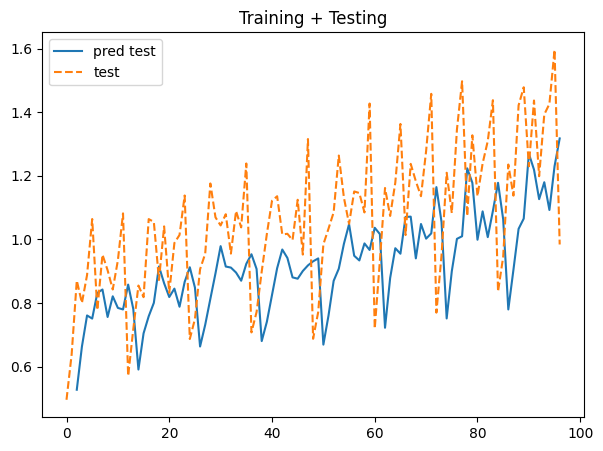

In [ ]:
fig = plt.figure(figsize=(7,5))
plt.plot(np.arange(time_steps,len(train_y_predL)+time_steps), train_y_predL, label='pred train')
plt.plot(train_y_dense[:-time_steps],'--', label ='train')
plt.plot(np.arange(len(train_y_predL)+time_steps+1, len(train_y_predL)+time_steps+len(test_y_predL)+1), test_y_predL, label='pred test')
plt.plot(np.arange(len(train_y_predL)+time_steps, len(train_y_predL)+time_steps+len(test_y_rec[:-time_steps])), test_y_rec[:-time_steps], '--', label='test')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()

fig = plt.figure(figsize=(7,5))
plt.plot(np.arange(time_steps, len(test_y_predL)+time_steps), test_y_predL, label='pred test')
plt.plot(test_y_rec, '--', label='test')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()

## Parte 3: Camada Self-Attention


In [ ]:
class SelfAttentionLayer(layers.Layer):
    def __init__(self, return_sequences=False):
        super(SelfAttentionLayer, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W_q = self.add_weight(name="W_q", shape=(input_shape[-1], input_shape[-1]), trainable=True)
        self.W_k = self.add_weight(name="W_k", shape=(input_shape[-1], input_shape[-1]), trainable=True)
        self.W_v = self.add_weight(name="W_v", shape=(input_shape[-1], input_shape[-1]), trainable=True)

    def call(self, inputs):
        q = tf.matmul(inputs, self.W_q)
        k = tf.matmul(inputs, self.W_k)
        v = tf.matmul(inputs, self.W_v)

        # Calculate attention scores using dot product
        attn_score = tf.matmul(q, k, transpose_b=True)

        # Apply softmax activation to get attention weights
        attn_score = tf.nn.softmax(attn_score, axis=-1)

        # Weighted sum using the attention scores
        output = tf.matmul(attn_score, v)

        if self.return_sequences:
            return output
        else:
            return tf.reduce_sum(output, axis=1)

In [ ]:
batch_size = 1

def create_LSTM_with_attention(no_features, time_steps, hidden_units=10, activation='relu', do_rate=0.2):

    x = layers.Input(shape=(time_steps, no_features))

    lstm_x = layers.LSTM(hidden_units, return_sequences=True, activation=activation)(x)
    #lstm_x = layers.LSTM(hidden_units, return_sequences=True, activation=activation)(lstm_x)
    attention = SelfAttentionLayer()(lstm_x)

    attention_drop = layers.Dropout(do_rate)(attention)
    outputs = layers.Dense(1, trainable=True, activation=activation)(attention_drop)
    model = tf.keras.models.Model(x, outputs)
    return model

modelAtt = create_LSTM_with_attention(no_features, time_steps, hidden_units=16, do_rate=0.25)
modelAtt.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2, 1)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 2, 16)             1152      
                                                                 
 self_attention_layer_2 (Se  (None, 16)                768       
 lfAttentionLayer)                                               
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1937 (7.57 KB)
Trainable params: 1937 (7.57 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________

In [ ]:
modelAtt = create_LSTM_with_attention(no_features, time_steps, hidden_units=16, do_rate=0.25)

# compilacao e treinamento
modelAtt.compile(loss='mean_squared_error',
            optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0002),
            metrics=['mae'])

histAtt = modelAtt.fit(train_x_rec, train_y_rec,
                  batch_size=batch_size, epochs=epochs,
                  callbacks=[callbacklr], shuffle=False,
                  verbose=1)

Epoch 1/35
225/225 [==============================] - 2s 3ms/step - loss: 0.0914 - mae: 0.2671 - lr: 2.0000e-04
Epoch 2/35
225/225 [==============================] - 1s 3ms/step - loss: 0.0248 - mae: 0.1243 - lr: 2.0000e-04
Epoch 3/35
225/225 [==============================] - 1s 3ms/step - loss: 0.0243 - mae: 0.1255 - lr: 2.0000e-04
Epoch 4/35
225/225 [==============================] - 1s 3ms/step - loss: 0.0268 - mae: 0.1291 - lr: 2.0000e-04
Epoch 5/35
225/225 [==============================] - 1s 5ms/step - loss: 0.0236 - mae: 0.1222 - lr: 1.9604e-04
Epoch 6/35
225/225 [==============================] - 1s 3ms/step - loss: 0.0239 - mae: 0.1214 - lr: 1.9216e-04
Epoch 7/35
225/225 [==============================] - 1s 3ms/step - loss: 0.0242 - mae: 0.1207 - lr: 1.8835e-04
Epoch 8/35
225/225 [==============================] - 1s 3ms/step - loss: 0.0218 - mae: 0.1176 - lr: 1.8462e-04
Epoch 9/35
225/225 [==============================] - 1s 3ms/step - loss: 0.0221 - mae: 0.1165 - lr: 1.8

Scores treinamento
MSE: 0.0141
MAE: 0.0899


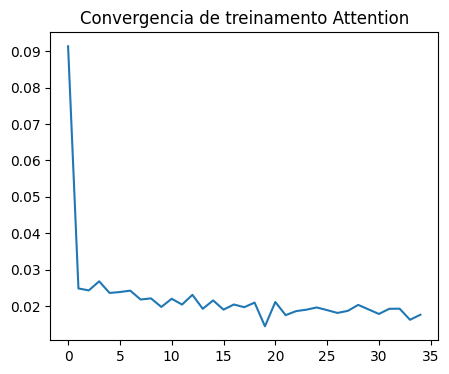

In [ ]:
scores = modelAtt.evaluate(train_x_rec, train_y_rec, batch_size=batch_size, verbose=0)
print('Scores treinamento')
print('MSE: %.4f' % (scores[0]))
print('MAE: %.4f' % (scores[1]))

plt.figure(figsize=(5,4))
plt.plot(histAtt.history['loss'])
ax = plt.title('Convergencia de treinamento Attention')

In [ ]:
# realiza predicoes com os dados de treinamento e teste
train_y_predG = modelAtt.predict(train_x_rec,batch_size=batch_size)
train_y_predG = np.reshape(train_y_predG, (-1, 1))[time_steps:]

test_y_predG = modelAtt.predict(test_x_rec,batch_size=batch_size)
test_y_predG = np.reshape(test_y_predG, (-1, 1))[time_steps:]

97/97 [==============================] - 0s 2ms/step


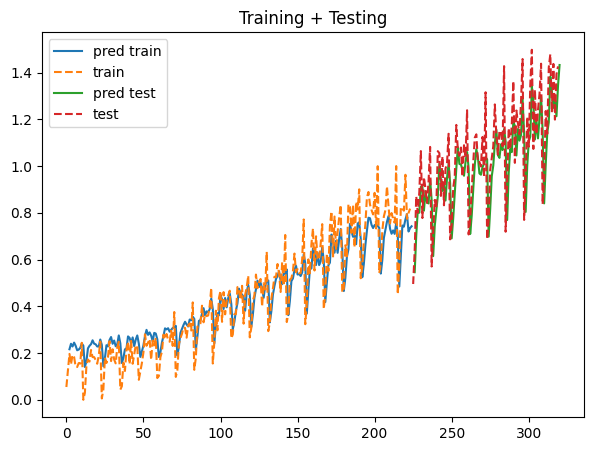

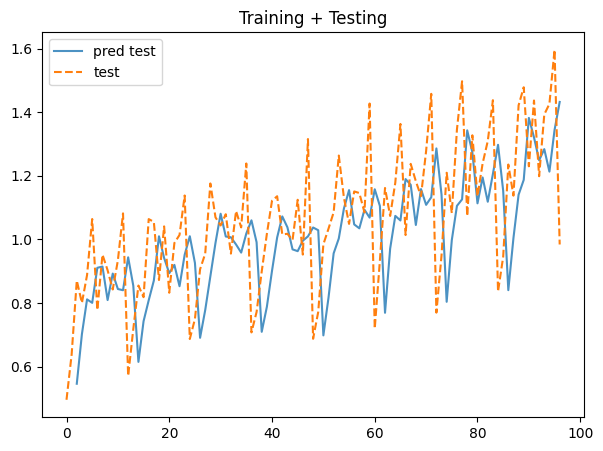

In [ ]:
fig = plt.figure(figsize=(7,5))

plt.plot(np.arange(time_steps,len(train_y_predG)+time_steps), train_y_predL, label='pred train')
plt.plot(train_y_dense[:-time_steps],'--', label ='train')
plt.plot(np.arange(len(train_y_predG)+time_steps+1, len(train_y_predG)+time_steps+len(test_y_predG)+1), test_y_predG, label='pred test')
plt.plot(np.arange(len(train_y_predG)+time_steps, len(train_y_predG)+time_steps+len(test_y_rec[:-time_steps])), test_y_rec[:-time_steps], '--', label='test')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()

fig = plt.figure(figsize=(7,5))
plt.plot(np.arange(time_steps,len(test_y_predG)+time_steps),test_y_predG, alpha=0.8, label='pred test')
plt.plot(test_y_rec, '--', label='test')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()

In [ ]:
# avaliacao da predição ponto a ponto
print("Erro no teste com predição a cada ponto:")
scoreLSTM = modelLSTM.evaluate(test_x_rec, test_y_rec, batch_size = batch_size, verbose=0)
print(f"LSTM    : MSE={scoreLSTM[0]:.4f}, MAE={scoreLSTM[1]:.4f})")
scoreAtt = modelAtt.evaluate(test_x_rec, test_y_rec, batch_size = batch_size, verbose=0)
print(f"LSTM+Att: MSE={scoreAtt[0]:.4f}, MAE={scoreAtt[1]:.4f})")

Erro no teste com predição a cada ponto:
LSTM    : MSE=0.0626, MAE=0.2195)
LSTM+Att: MSE=0.0494, MAE=0.1871)


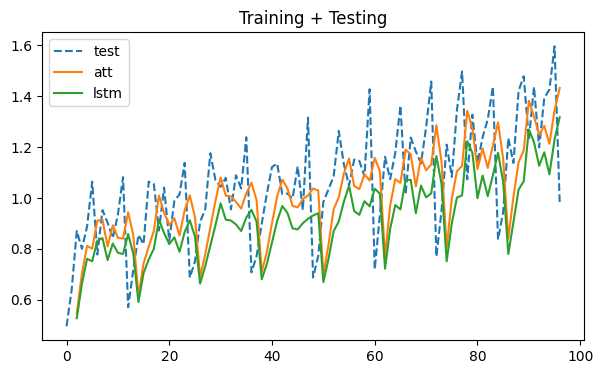

In [ ]:
fig = plt.figure(figsize=(7,4))
plt.plot(test_y_rec, '--', label='test')
# plt.plot(test_y_predL, '--', alpha=0.8, label='lstm')
# plt.plot(test_y_predG, '--', alpha=0.8, label='att')
plt.plot(np.arange(time_steps,len(test_y_predG)+time_steps),test_y_predG, label='att')
plt.plot(np.arange(time_steps,len(test_y_predL)+time_steps),test_y_predL, label='lstm')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()